In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from netCDF4 import Dataset
import utils as utl

In [3]:
Nh = 96
Nt = 37
sspacing = 3
tspacing = 4

HTLS_sknots = np.arange(0,Nh,sspacing)
HTHS_sknots = np.arange(0,Nh,1)
LTHS_tknots = np.arange(0,Nh,tspacing)
Nl = len(HTLS_sknots)
Ns = len(LTHS_tknots)

N = Nt*Ns

[]

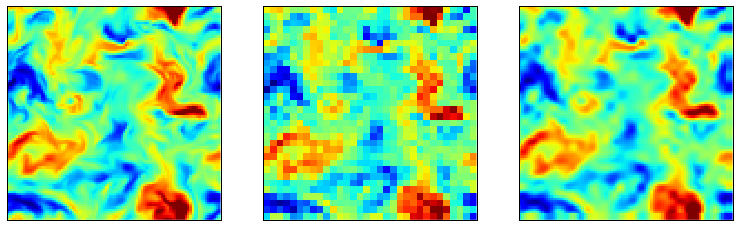

In [4]:
ncfile1 = Dataset('/data/ISOTROPIC/data/data_downsampled4.nc','r')
x_HR_ref = np.array(ncfile1.variables['velocity_x'][0,0:Nh,0:Nh,0])
ncfile1.close()
x_LR = x_HR_ref[0:-1:sspacing,0:-1:sspacing]
x_interp = utl.interp2(HTLS_sknots, HTLS_sknots, x_LR, HTHS_sknots, HTHS_sknots)

fig = plt.figure(figsize=(13, 5))

ax = plt.subplot(1,3, 1)
cax = plt.imshow(x_HR_ref, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())
    
ax = plt.subplot(1,3, 2)
cax = plt.imshow(x_LR, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(1,3, 3)
cax = plt.imshow(x_interp, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

In [5]:
Np = 3 # haft number of predictor
offset = np.arange(-Np*sspacing,(Np+1)*sspacing+1,sspacing)
patchsize_o = len(offset) 
zz_o, yy_o, zz_i, yy_i = utl.gen_grids(sspacing, sspacing, Nh, Np) 

Do = (sspacing+1)*(sspacing+1) # dimension of the HR vector to reconstruct
Di = patchsize_o*patchsize_o # number of LR predictors


Xo_tr = np.zeros((Nt*Ns*Nl*Nl, Do))
Xi_tr = np.zeros((Nt*Ns*Nl*Nl, Di))
ncfile1 = Dataset('/data/ISOTROPIC/data/data_downsampled4.nc','r')

for t in range(Nt):
    count = 0
    for i in LTHS_tknots:
        xh = np.array(ncfile1.variables['velocity_x'][t,0:Nh,0:Nh,i])
        patches_o = xh[yy_o,zz_o]
        patches_i = xh[yy_i, zz_i]
        Xo_tr[(t*Ns+ count)*Nl*Nl:(t*Ns+ count + 1)*Nl*Nl,:] = np.reshape(patches_o,(Nl*Nl, Do))
        Xi_tr[(t*Ns+ count)*Nl*Nl:(t*Ns+ count + 1)*Nl*Nl,:] = np.reshape(patches_i,(Nl*Nl, Di)) 
        # reshape will take from last index toward first one
        count = count + 1
ncfile1.close()

# normalized: centered, variance 1
mea_i = np.zeros(Di)
sig_i = np.zeros(Di)
for k in range(Di):
    mea_i[k] = np.mean(Xi_tr[:,k])
    sig_i[k] = np.std(Xi_tr[:,k])
    Xi_tr[:,k] = (Xi_tr[:,k]-mea_i[k])/sig_i[k]
    
mea_o = np.zeros(Do)
sig_o = np.zeros(Do)
for k in range(Do):
    mea_o[k] = np.mean(Xo_tr[:,k])
    sig_o[k] = np.std(Xo_tr[:,k])
    Xo_tr[:,k] = (Xo_tr[:,k]-mea_o[k])/sig_o[k]    
    
print "Xo_tr is of size:", np.shape(Xo_tr)
print "Xi_tr is of size:", np.shape(Xi_tr) 
 

Xo_tr is of size: (909312, 16)
Xi_tr is of size: (909312, 64)


In [10]:
from sklearn.kernel_ridge import KernelRidge
estimator = KernelRidge(kernel='rbf', alpha=0.0001, gamma=10e-5)

#from sklearn.svm import SVR
#estimator = SVR(kernel='rbf',gamma=10e-5)

Ntr = 10000
ids = np.random.permutation(np.shape(Xo_tr)[0])[0:Ntr]

estimator.fit(Xi_tr[ids,:],Xo_tr[ids,:])

KernelRidge(alpha=0.0001, coef0=1, degree=3, gamma=0.0001, kernel='rbf',
      kernel_params=None)

In [11]:
t=0
i=3

ncfile1 = Dataset('/data/ISOTROPIC/data/data_downsampled4.nc','r')
xh = np.array(ncfile1.variables['velocity_x'][t,0:Nh,0:Nh,i])
ncfile1.close()

xl = xh[0:-1:sspacing,0:-1:sspacing]
x_interp = utl.interp2(HTLS_sknots, HTLS_sknots, xl, HTHS_sknots, HTHS_sknots)

# patches_HR = xh[yy_HR,zz_HR]
patches_i = xh[yy_i,zz_i]
patches_i = np.divide(np.reshape(patches_i,(Nl*Nl, Di)) - np.tile(mea_i, [Nl*Nl, 1]), 
                       np.tile(sig_i, [Nl*Nl, 1]))

patches_o = estimator.predict(patches_i)
patches_o = np.multiply(patches_o, np.tile(sig_o, [Nl*Nl, 1])) + np.tile(mea_o, [Nl*Nl, 1])

In [12]:
xh_rec = np.zeros((Nh,Nh))
w = np.zeros((Nh,Nh))
xh_rec[yy_o,zz_o] = xh_rec[yy_o,zz_o] + np.reshape(patches_o,(Nl,Nl,4,4))
w[yy_o,zz_o] = w[yy_o,zz_o] + 1

xh_rec = np.divide(xh_rec, w)

0.905757326263


[]

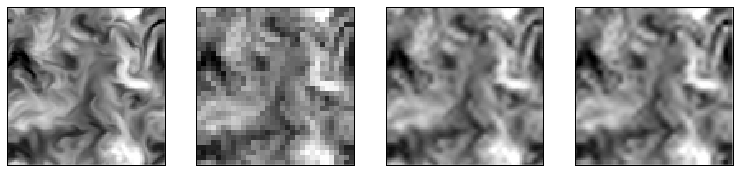

In [13]:
NRMSE_KRR = utl.NRMSE(xh,xh_rec)
NRMSE_interp = utl.NRMSE(xh,x_interp)

print NRMSE_KRR/NRMSE_interp

fig = plt.figure(figsize=(13, 5))

ax = plt.subplot(1,4, 1)
cax = plt.imshow(xh, interpolation='none',clim=[-3,3],cmap='gray')
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(1,4, 2)
cax = plt.imshow(xl, interpolation='none',clim=[-3,3],cmap='gray')
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(1,4, 3)
cax = plt.imshow(xh_rec, interpolation='none',clim=[-3,3],cmap='gray')
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(1,4, 4)
cax = plt.imshow(x_interp, interpolation='none',clim=[-3,3],cmap='gray')
ax.set_xticks(())
ax.set_yticks(())